## 1. Basic step

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from sklearn.metrics import r2_score

# Connect with Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

data_dir = "/content/gdrive/My Drive/data/"
print(os.listdir(data_dir))

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
['PJM_Load_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv']


## 2. Data loading and data exploration

In [2]:
# First, we get the data
file_path = data_dir + 'AEP_hourly.csv'
df = pd.read_csv(file_path, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [3]:
# Checking for missing values
df.isna().sum()

AEP_MW    0
dtype: int64

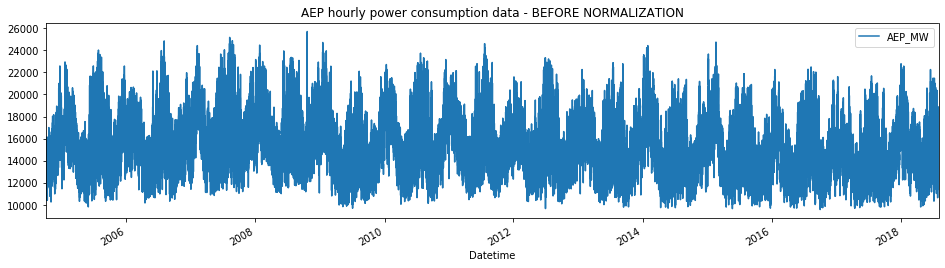

In [4]:
# Data visualization
df.plot(figsize=(16,4),legend=True)
plt.title('AEP hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [5]:
# Normalize data
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

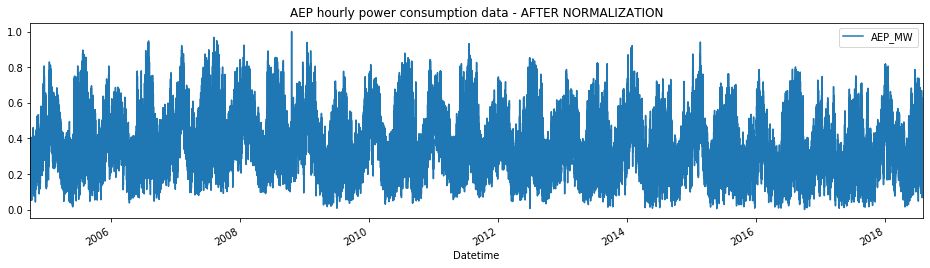

In [6]:
# Data visualization after normalization
df_norm.plot(figsize=(16,4),legend=True)
plt.title('AEP hourly power consumption data - AFTER NORMALIZATION')
plt.show()

## 3. Prepare data for training the RNN models

In [0]:
def load_data(stock, seq_len):
    x_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        x_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6273 data are going to be used in test
    x_test = x_train[115000:]             
    y_test = y_train[115000:]
    
    #2 first 110000 data are going to be used in training
    x_train = x_train[:115000]           
    y_train = y_train[:115000]
    
    #3 convert to numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    x_train = np.reshape(x_train, (115000, seq_len, 1))
    x_test = np.reshape(x_test, (x_test.shape[0], seq_len, 1))
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# Create train, test data
seq_len = 20 # Choose sequence length

x_train, y_train, x_test, y_test = load_data(df, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (115000, 20, 1)
y_train.shape =  (115000,)
x_test.shape =  (6253, 20, 1)
y_test.shape =  (6253,)


## 4. Build a simple RNN model

In [43]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_26 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [44]:
start_time = time.clock()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(x_train, y_train, epochs=10, batch_size=1000)
current_time = time.clock()
print("Training Time : {} seconds".format(str(current_time-start_time)))

Train on 115000 samples
Epoch 1/10
115000/115000 [==============================] - 8s 71us/sample - loss: 0.1091
Epoch 2/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0227
Epoch 3/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0127
Epoch 4/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0089
Epoch 5/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0068
Epoch 6/10
115000/115000 [==============================] - 5s 46us/sample - loss: 0.0055
Epoch 7/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0047
Epoch 8/10
115000/115000 [==============================] - 5s 47us/sample - loss: 0.0042
Epoch 9/10
115000/115000 [==============================] - 5s 43us/sample - loss: 0.0037
Epoch 10/10
115000/115000 [==============================] - 5s 45us/sample - loss: 0.0033
Training Time : 77.47840500000001 seconds


In [45]:
# Check r2 score for the values predicted by the above trained SIMPLE RNN model
rnn_predictions = rnn_model.predict(x_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9627774160226044


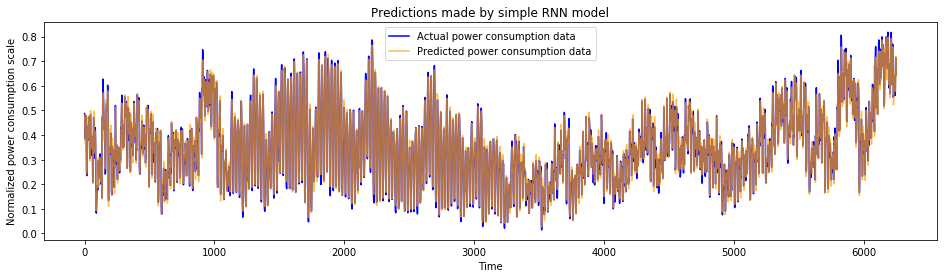

In [12]:
# Compare the actual values and predicted values by plotting a graph
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## 5. Build an LSTM model

In [29]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
start_time = time.clock()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(x_train, y_train, epochs=10, batch_size=1000)
current_time = time.clock()
print("Training Time : {} seconds".format(str(current_time-start_time)))

Train on 115000 samples
Epoch 1/10
115000/115000 [==============================] - 5s 47us/sample - loss: 0.0259
Epoch 2/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0156
Epoch 3/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0075
Epoch 4/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0051
Epoch 5/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0035
Epoch 6/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0028
Epoch 7/10
115000/115000 [==============================] - 1s 11us/sample - loss: 0.0024
Epoch 8/10
115000/115000 [==============================] - 1s 11us/sample - loss: 0.0021
Epoch 9/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0020
Epoch 10/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0018
Training Time : 19.627670999999964 seconds


In [39]:
# Check r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(x_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model = ",lstm_score)

R2 Score of LSTM model =  0.9647909940346755


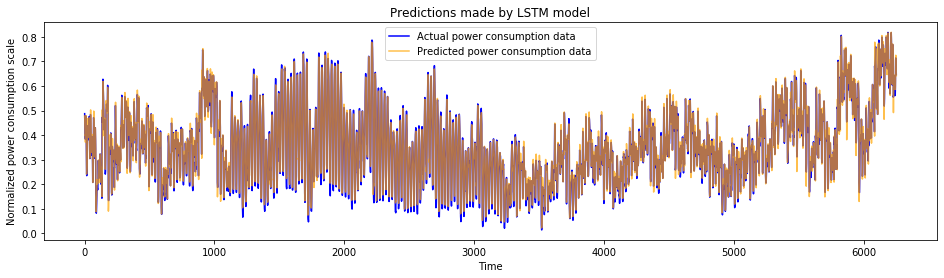

In [33]:
# Compare the actual values and predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

## 6. Build a GRU model

In [40]:
gru_model = Sequential()

gru_model.add(GRU(40,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],1)))
gru_model.add(Dropout(0.15))

gru_model.add(GRU(40,activation="tanh",return_sequences=True))
gru_model.add(Dropout(0.15))

gru_model.add(GRU(40,activation="tanh",return_sequences=False))
gru_model.add(Dropout(0.15))

gru_model.add(Dense(1))

gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 20, 40)            5160      
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 20, 40)            9840      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 40)                9840      
_________________________________________________________________
dropout_23 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [41]:
start_time = time.clock()
gru_model.compile(optimizer="adam",loss="MSE")
gru_model.fit(x_train, y_train, epochs=10, batch_size=1000)
current_time = time.clock()
print("Training Time : {} seconds".format(str(current_time-start_time)))

Train on 115000 samples
Epoch 1/10
115000/115000 [==============================] - 5s 42us/sample - loss: 0.0190
Epoch 2/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0050
Epoch 3/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0032
Epoch 4/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0025
Epoch 5/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0022
Epoch 6/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0019
Epoch 7/10
115000/115000 [==============================] - 1s 11us/sample - loss: 0.0018
Epoch 8/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0017
Epoch 9/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0016
Epoch 10/10
115000/115000 [==============================] - 1s 10us/sample - loss: 0.0016
Training Time : 18.03053 seconds


In [42]:
# Check r2 score for the values predicted by the above trained GRU model
gru_predictions = gru_model.predict(x_test)

gru_score = r2_score(y_test, gru_predictions)
print("R2 Score of GRU model = ",gru_score)

R2 Score of GRU model =  0.9634089347621781


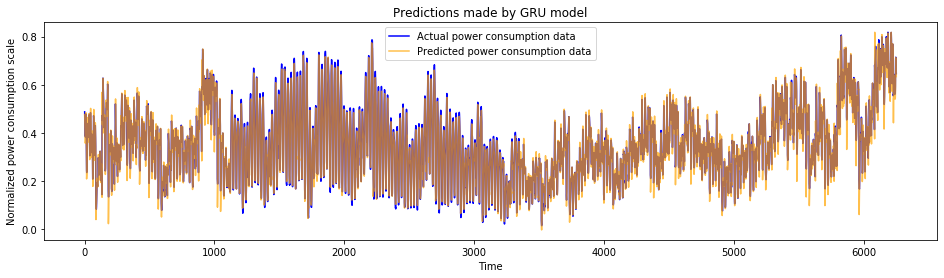

In [36]:
# Compare the actual values and predicted values by plotting a graph
plot_predictions(y_test, gru_predictions, "Predictions made by GRU model")

## 7. Compare predictions made by simple RNN, LSTM, GRU model

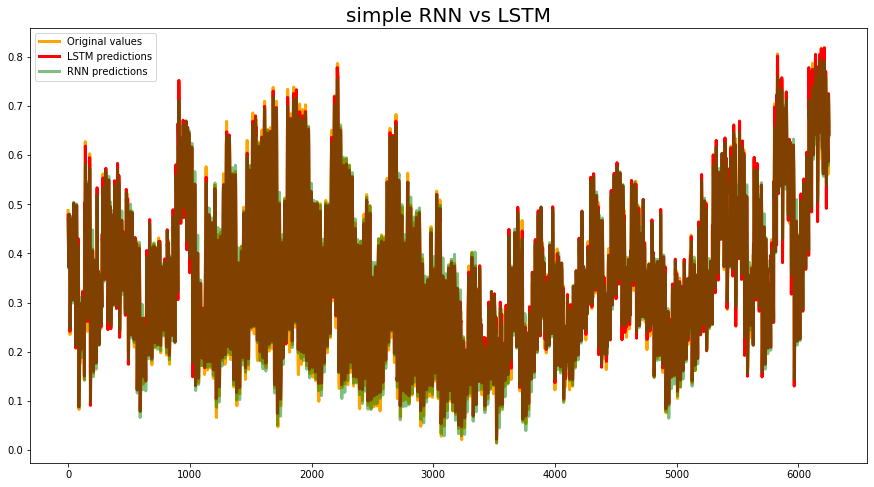

In [46]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("simple RNN vs LSTM", fontsize=20)
plt.show()

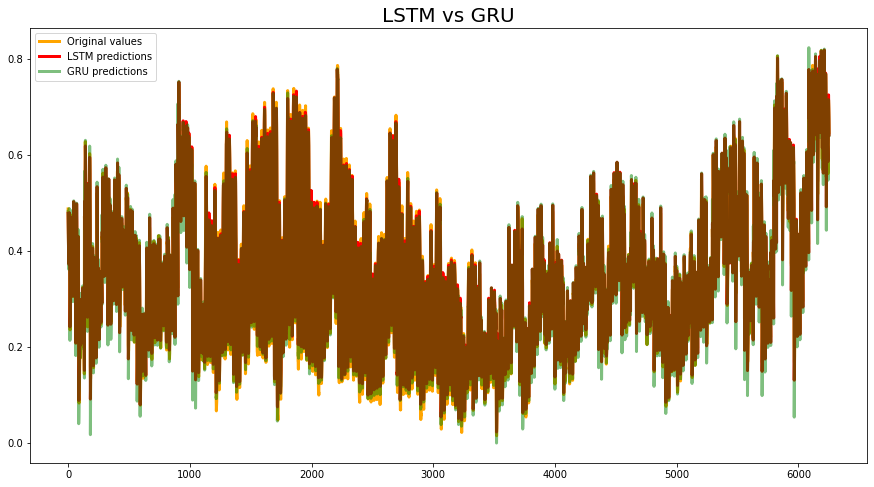

In [47]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(gru_predictions, alpha=0.5, c="green", linewidth=3, label="GRU predictions")
plt.legend()
plt.title("LSTM vs GRU", fontsize=20)
plt.show()